In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from IPython.display import display, Math
from scipy.optimize import minimize
import astropy.units as u
from astropy.modeling.models import custom_model
from scipy import interpolate
import keras
from scipy.optimize import Bounds
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
import LUCI.LuciFit as lfit
import emcee
import corner


In [2]:
# Read in Data

sigma_info = []
velocity_info = []
res_info = []
spectrum = fits.open('../Data/Reference-Spectrum-R5000.fits')
header = spectrum[0].header
spec = spectrum[1].data
channel = []
counts = []
for chan in spec:
    channel.append(chan[0])
    counts.append(chan[1])

axis = channel
sky = counts
velocity = header['VELOCITY']
sigma = header['BROADEN']
print(velocity, sigma)

0 10


In [3]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('../ML/Reference-Spectrum-R5000-SN3.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]

In [4]:
f = interpolate.interp1d(axis, sky, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale
print(sky_corr.shape)

(460,)


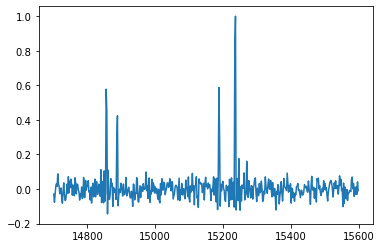

In [5]:
plt.plot(wavenumbers_syn, sky_corr)

In [6]:
fit = lfit.Fit(sky, axis, wavenumbers_syn, 'sincgauss', ['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], [1,3,3,2,2], [1,3,3,2,2],
                keras.models.load_model('../ML/R5000-PREDICTOR-I-SN3'),
                 bayes_bool=False, bayes_method='emcee')
fit_dict = fit.fit()
print(fit_dict['sigmas'])
print(fit_dict['fit_sol'])

2022-03-24 14:57:33.225405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 14:57:33.226490: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


[8.426865303409642, 8.37763501888808, 8.37763501803055, 8.476878551410712, 8.476878553051758]
[9.51232857e-01 1.52365799e+04 1.00853559e+00 5.18932187e-01
 1.51888803e+04 9.99504791e-01 1.72955948e-01 1.52709481e+04
 1.00490527e+00 4.14901155e-01 1.48879734e+04 9.91309411e-01
 5.48487271e-01 1.48561662e+04 9.89191546e-01 3.68567629e-06]


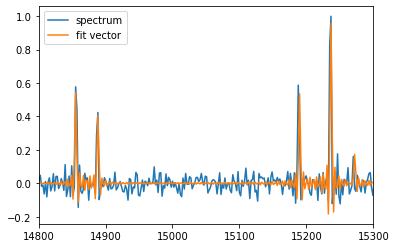

In [7]:
plt.plot(axis, sky, label='spectrum')
plt.plot(axis, fit_dict['fit_vector'], label='fit vector')
plt.xlim(14800, 15300)
plt.legend()

In [8]:
fit_dict['sigmas']

[8.426865303409642,
 8.37763501888808,
 8.37763501803055,
 8.476878551410712,
 8.476878553051758]

In [9]:
fit_dict['velocities']

[16.11008644105979,
 16.11008654322705,
 16.11008654327882,
 16.11008643439993,
 16.110086434407727]